In [1]:
# all of this from BetterNotebooks.ipynb
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2)
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
import os
from IPython.core.display import HTML

In [2]:
title_approaches = {
    'faircal':'Faircal (Theirs)',
    'gmm-discrete':'GMM-Discrete (Ours)'
    }
title_calibration_methods = {
    'beta': 'Beta Calibration'
}
title_features = {
    'facenet':'FaceNet (VGGFace2)',
    'facenet-webface':'FaceNet (Webface)',
    'arcface': 'ArcFace'}

title_metrics = {
    'mean': 'Mean',
    'aad': 'AAD',
    'mad': 'MAD',
    'std': 'STD'}

caption_metrics = {
     'mean': 'Mean',
     'aad': 'AAD (Average Absolute Deviation)',
     'mad': 'MAD (Maximum Absolute Deviation)',
     'std': 'STD (Standard Deviation)',
}

title_keys = {
    'gmm-discrete': 'GMM-Discrete (Ours)',
    'faircal':'Faircal (Theirs)'
    }

header_titles = {
    'African': 'Af',
    'Asian': 'As',
    'Caucasian': 'Ca',
    'Indian': 'In',
    'asian_females': 'AsF',
    'asian_males': 'AsM',
    'black_females': 'AfF',
    'black_males': 'AfM',
    'indian_females': 'IF',
    'indian_males': 'IM',
    'white_females': 'CF',
    'white_males': 'CM',
    'Global': 'Gl',
    'B': 'Af',
    'A': 'As',
    'W': 'C',
    'I': 'I',
    'F': 'F',
    'M': 'M'
}
title_datasets = {
    'rfw': 'RFW',
    'bfw': 'BFW'
}
caption_calibration_methods = {
    'beta': 'beta calibration'
}
caption_measures = {
    'ks': 'KS',
    'ece': 'ECE',
    'brier': 'Brier',
}
features_datasets = {
#     'rfw': ['facenet', 'facenet-webface'],
    'bfw': ['facenet-webface', 'arcnet']
}
attributes_datasets = {
    'rfw': 'ethnicity',
    'bfw': 'att',
}

In [3]:
def load_measures(dataset, feature, approach, subgroups, att, measure, calibration_method, nbins, n_clusters):
    filename = f'../experiments/{dataset}/{feature}/{approach}/{calibration_method}/nbins_{nbins}'
    filename += f'_nclusters_{n_clusters}'
    
    results = np.load(f'{filename}.npy', allow_pickle=True).item()

    data = pd.DataFrame()
    data['folds'] = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
    data = data.set_index('folds')
    for fold in range(1, 6):
        for j, subgroup in enumerate(subgroups[att]):
            data.loc[f'fold{str(fold)}', f'{subgroup}'] = results[f'fold{str(fold)}'][measure][att][subgroup]
    return data

In [4]:
subgroups = {
            'e':['B', 'A', 'W', 'I'],
            'g':['F','M'],
            'att': ['black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males']
        }
att = 'e'   
test = load_measures('bfw','facenet-webface','faircal',subgroups,att,'ks','beta',25,100)
print(test)

          B     A     W     I
folds                        
fold1  0.01  0.02  0.03  0.01
fold2  0.03  0.02  0.02  0.02
fold3  0.04  0.02  0.02  0.05
fold4  0.03  0.04  0.03  0.01
fold5  0.02  0.03  0.02  0.04


In [5]:
def get_sensitive_attributes_subgroups(dataset):
    if dataset == 'rfw':
        sensitive_attributes = ['ethnicity']
        subgroups = {'ethnicity':['African', 'Asian', 'Caucasian', 'Indian']}
    elif 'bfw' in dataset:
        sensitive_attributes = ['e', 'g', 'att']
        subgroups = {
            'e':['B', 'A', 'W', 'I'],
            'g':['F','M'],
            'att': ['black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males']
        }
    return sensitive_attributes, subgroups

In [10]:
n_clusters = [500, 250, 150, 75, 50, 25, 15, 10, 5, 1]
folds = [1,2,3,4,5]
data = pd.DataFrame()

measure = 'ks'
calibration = 'beta'

indices = {
#     'rfw' : {
#         'facenet': ['African', 'Asian', 'Caucasian', 'Indian'],
#         'facenet-webface': ['African', 'Asian', 'Caucasian', 'Indian'],
#     },
    'bfw' : {
        'facenet-webface': ['B', 'A', 'W', 'I', 'F','M', 
            'black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males'],
        'arcface': ['B', 'A', 'W', 'I', 'F','M', 
            'black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males']

        }
    }

# Create tuples from multi-indices
approaches = ['faircal', 'gmm-discrete']
tuples = []
for dataset in indices:
    for feature, sens in indices[dataset].items():
        for n_cluster in n_clusters:
            for approach in approaches:
                tuples.append((dataset, feature, n_cluster, approach))

index = pd.MultiIndex.from_tuples(tuples, names=['dataset', 'feature', 'n_clusters', 'approach'])

data = pd.DataFrame(index=index)
for metric in ['mean', 'aad', 'mad', 'std']:
    data[metric] = np.nan

# For now, because we only have one experiment
for dataset in indices:
    for feature in indices[dataset]:
        for approach in approaches:
            sensitive_attributes, subgroups = get_sensitive_attributes_subgroups(dataset)
            for n_cluster in n_clusters:
                nbins = 25 if dataset == 'bfw' else 10
                data_work = load_measures(dataset, feature, approach, subgroups, att, measure, 'beta', nbins=nbins, n_clusters=n_cluster)
                data_work = data_work * 100

                all_subgroups = []
                for subgroup in data_work.columns:
                    all_subgroups.append(data_work[subgroup].tolist())
                    
                all_subgroups = np.hstack(all_subgroups)
                group_mean = all_subgroups.mean()
                
#                 plt.hist(all_subgroups, bins=20)
                print([dataset, feature, approach, str(n_cluster)])
#                 plt.show()
                
                data.loc[dataset, feature, n_cluster, approach]['mean'] = group_mean
                data.loc[dataset, feature, n_cluster, approach]['aad'] = np.abs(all_subgroups - group_mean).mean()
                data.loc[dataset, feature, n_cluster, approach]['mad'] = np.abs(all_subgroups - group_mean).max()
                data.loc[dataset, feature, n_cluster, approach]['std'] = np.std(all_subgroups)

HTML(data.to_html())

['bfw', 'facenet-webface', 'faircal', '500']
['bfw', 'facenet-webface', 'faircal', '250']
['bfw', 'facenet-webface', 'faircal', '150']
['bfw', 'facenet-webface', 'faircal', '75']
['bfw', 'facenet-webface', 'faircal', '50']
['bfw', 'facenet-webface', 'faircal', '25']
['bfw', 'facenet-webface', 'faircal', '15']
['bfw', 'facenet-webface', 'faircal', '10']
['bfw', 'facenet-webface', 'faircal', '5']
['bfw', 'facenet-webface', 'faircal', '1']
['bfw', 'facenet-webface', 'gmm-discrete', '500']
['bfw', 'facenet-webface', 'gmm-discrete', '250']
['bfw', 'facenet-webface', 'gmm-discrete', '150']
['bfw', 'facenet-webface', 'gmm-discrete', '75']
['bfw', 'facenet-webface', 'gmm-discrete', '50']
['bfw', 'facenet-webface', 'gmm-discrete', '25']
['bfw', 'facenet-webface', 'gmm-discrete', '15']
['bfw', 'facenet-webface', 'gmm-discrete', '10']
['bfw', 'facenet-webface', 'gmm-discrete', '5']
['bfw', 'facenet-webface', 'gmm-discrete', '1']
['bfw', 'arcface', 'faircal', '500']
['bfw', 'arcface', 'faircal', '

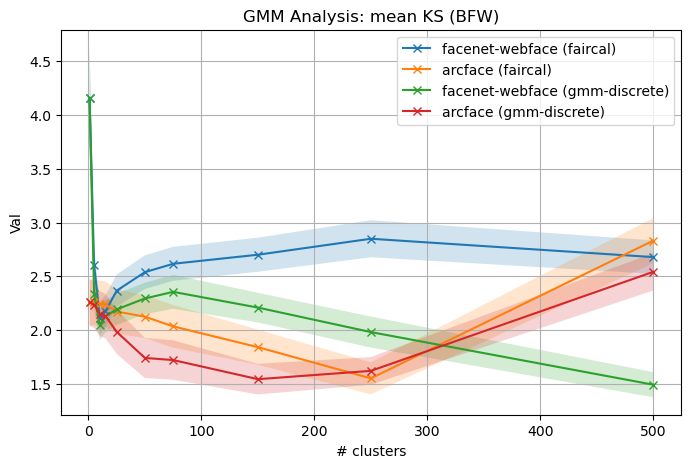

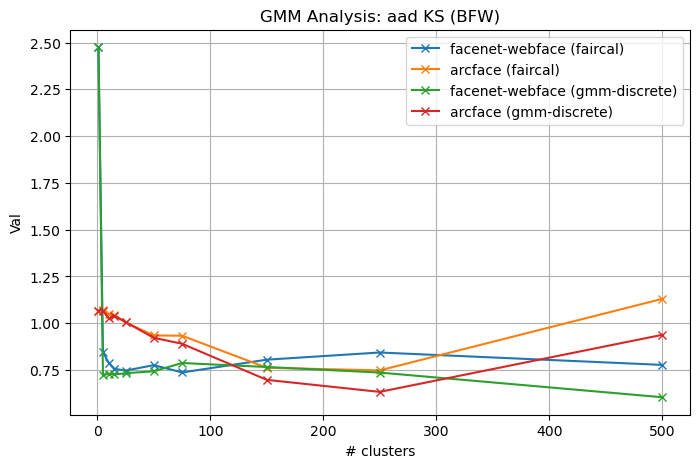

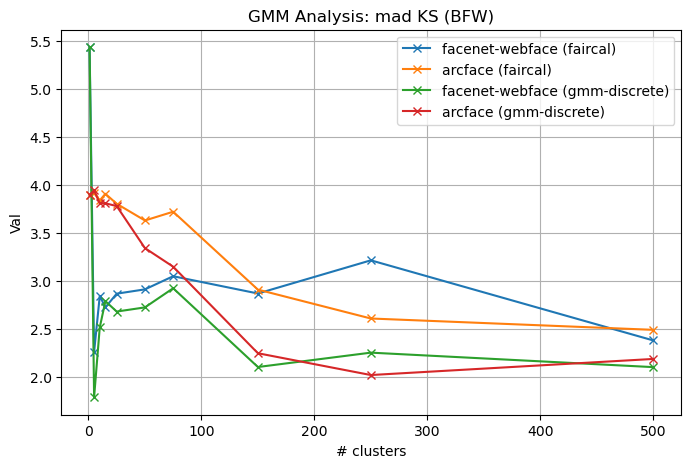

In [11]:
data = data.sort_index()

for metric in ['mean', 'aad', 'mad']:
    plt.figure(figsize=(8, 5))
    for approach in approaches:
        for model in ["facenet-webface", "arcface"]:
            x = data[f'{metric}']["bfw", model, :, approach].index
            y = data[f'{metric}']["bfw", model, :, approach]

            plt.plot(x,y,label=model+f" ({approach})", marker='x')
            if metric == 'mean':
                error = data['std']["bfw", model, :, approach]/np.sqrt(40)
                plt.fill_between(x, y-error, y+error, alpha=0.2)

    plt.legend(loc="upper right")
    plt.grid()
    plt.xlabel("# clusters")
    plt.ylabel("Val")
    plt.title(f"GMM Analysis: {metric} {measure.upper()} (BFW)")

    plt.show()

In [12]:
new_df = data[['mean', 'std']]
new_df.sort_index()
new_df['lb'] = np.nan
new_df['ub'] = np.nan
new_df['sig'] = np.nan

for dataset in ['bfw']:
    for model in ["facenet-webface", "arcface"]:
        for n_cluster in n_clusters:
            mean_fc = new_df['mean'][dataset, model, n_cluster, "faircal"]
            mean_gmm = new_df['mean'][dataset, model, n_cluster, "gmm-discrete"]
            std_fc = new_df['std'][dataset, model, n_cluster, "faircal"]
            std_gmm = new_df['std'][dataset, model, n_cluster, "gmm-discrete"]
            
            mean_diff = mean_fc - mean_gmm
            pooled_se = np.sqrt((std_fc**2)/40 + (std_gmm**2)/40)
            
            lb = mean_diff - 1.96*pooled_se
            ub = mean_diff + 1.96*pooled_se
            
            new_df['ub'][dataset, model, n_cluster, "faircal"] = ub
            new_df['lb'][dataset, model, n_cluster, "faircal"] = lb
            new_df['sig'][dataset, model, n_cluster, "faircal"] = not(lb <= 0 <= ub)


new_df['sig'] = new_df['sig'].astype(str).replace({"nan":""})

new_df

C:\Users\satch\AppData\Local\Temp\ipykernel_66480\3772987220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['lb'] = np.nan
C:\Users\satch\AppData\Local\Temp\ipykernel_66480\3772987220.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ub'][dataset, model, n_cluster, "faircal"] = ub
C:\Users\satch\AppData\Local\Temp\ipykernel_66480\3772987220.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

mean   std    lb    ub    sig
dataset feature         n_clusters approach                                   
bfw     arcface         1          faircal       2.26  1.36 -0.60  0.60  False
                                   gmm-discrete  2.26  1.36   NaN   NaN       
                        5          faircal       2.26  1.37 -0.58  0.62  False
                                   gmm-discrete  2.24  1.37   NaN   NaN       
                        10         faircal       2.25  1.34 -0.49  0.68  False
                                   gmm-discrete  2.15  1.32   NaN   NaN       
                        15         faircal       2.24  1.35 -0.48  0.69  False
                                   gmm-discrete  2.13  1.32   NaN   NaN       
                        25         faircal       2.17  1.31 -0.38  0.76  False
                                   gmm-discrete  1.98  1.29   NaN   NaN       
                        50         faircal       2.12  1.25 -0.15  0.92  False
                                   gmm-discrete  1.74  1.18   NaN   NaN       
                        75         faircal       2.03  1.26 -0.22  0.84  False
                                   gmm-discrete  1.72  1.16   NaN   NaN       
                        150        faircal       1.84  1.03 -0.13  0.72  False
                                   gmm-discrete  1.54  0.90   NaN   NaN       
                        250        faircal       1.55  0.94 -0.46  0.32  False
                                   gmm-discrete  1.62  0.81   NaN   NaN       
                        500        faircal       2.83  1.33 -0.24  0.82  False
                                   gmm-discrete  2.54  1.10   NaN   NaN       
        facenet-webface 1          faircal       4.16  3.00 -1.32  1.32  False
                                   gmm-discrete  4.16  3.00   NaN   NaN       
                        5          faircal       2.61  1.06 -0.16  0.71  False
                                   gmm-discrete  2.34  0.93   NaN   NaN       
                        10         faircal       2.11  0.97 -0.34  0.48  False
                                   gmm-discrete  2.05  0.88   NaN   NaN       
                        15         faircal       2.17  0.93 -0.36  0.46  False
                                   gmm-discrete  2.13  0.94   NaN   NaN       
                        25         faircal       2.37  0.95 -0.24  0.58  False
                                   gmm-discrete  2.19  0.92   NaN   NaN       
                        50         faircal       2.54  0.99 -0.18  0.67  False
                                   gmm-discrete  2.29  0.93   NaN   NaN       
                        75         faircal       2.62  1.00 -0.18  0.70  False
                                   gmm-discrete  2.36  1.00   NaN   NaN       
                        150        faircal       2.70  1.00  0.08  0.90   True
                                   gmm-discrete  2.21  0.87   NaN   NaN       
                        250        faircal       2.85  1.09  0.43  1.31   True
                                   gmm-discrete  1.98  0.91   NaN   NaN       
                        500        faircal       2.68  0.98  0.81  1.57   True
                                   gmm-discrete  1.49  0.74   NaN   NaN

In [13]:
def get_overall_stats(calibration_method, nbins, dataset,feature,approach,att,n_clusters,fpr_def):
    filename = f'../experiments/{dataset}/{feature}/{approach}/{calibration_method}/nbins_{nbins}'
    filename += f'_nclusters_{n_clusters}'

    key = 'calibration' if approach in ['faircal', 'baseline', 'gmm-discrete'] else 'pre_calibration'
    
    results = np.load(f'{filename}.npy', allow_pickle=True).item()
    data = pd.DataFrame()
    data['folds'] = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
    data['auc'] = np.nan
    data['fpr_1e-3'] = np.nan
    data['fpr_1e-2'] = np.nan
    data = data.set_index('folds')

    for fold in range(1,6):
        fpr = results['fold'+str(fold)]['fpr'][att]['Global'][key]
        tpr = results['fold'+str(fold)]['tpr'][att]['Global'][key]
        data.loc[f'fold{str(fold)}', 'auc'] = sklearn.metrics.auc(fpr,tpr)
        inter = np.interp(fpr_def, fpr, tpr)
        data.iloc[fold-1, 1:] = inter
    return data

In [15]:
# Accuracy table
keys = ['faircal', 'gmm-discrete']
error = [1e-3, 1e-2]
title_stat = ['AUROC', '0.1\% FPR', '1\% FPR']
n_clusters = [500, 250, 150, 75, 50, 25, 15, 10, 5, 1]
calibration = 'beta'
datasets = ['bfw']

indices = {
#     'rfw' : ['facenet', 'facenet-webface'],
    'bfw' : ['facenet-webface', 'arcface']
}
approaches = ['faircal', 'gmm-discrete']

tuples = []
for dataset in indices:
    for feature in indices[dataset]:
        for cluster in n_clusters:
            for approach in approaches:
                tuples.append((dataset, feature, approach, cluster))

index = pd.MultiIndex.from_tuples(tuples, names=['dataset', 'feature', 'approach', 'clusters'])
data = pd.DataFrame(index=index)
metrics = ['auc', 'fpr_1e-3', 'fpr_1e-2']
for metric in metrics:
    data[metric] = ''

for dataset in indices:
    for feature in indices[dataset]:
        for cluster in n_clusters:
            for approach in approaches:
                nbins = 25 if dataset == 'bfw' else 10
                att = 'att' if dataset == 'bfw' else 'ethnicity'
                data_work = get_overall_stats(calibration, nbins, dataset, feature, approach, att, cluster, error)
                data_work *= 100
                for metric in metrics:
                    mean = round(data_work[metric].mean(), 2)
                    std = round(data_work[metric].std(), 2)
                    data.loc[dataset, feature, approach, cluster][metric] = f'{str(mean)} ({str(std)})'
                
HTML(data.to_html())

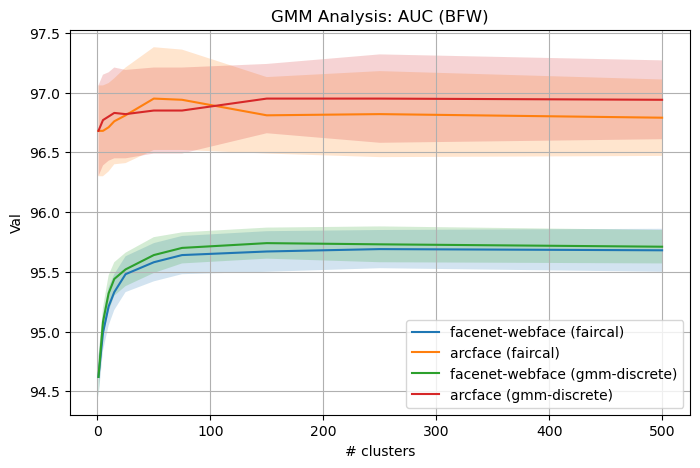

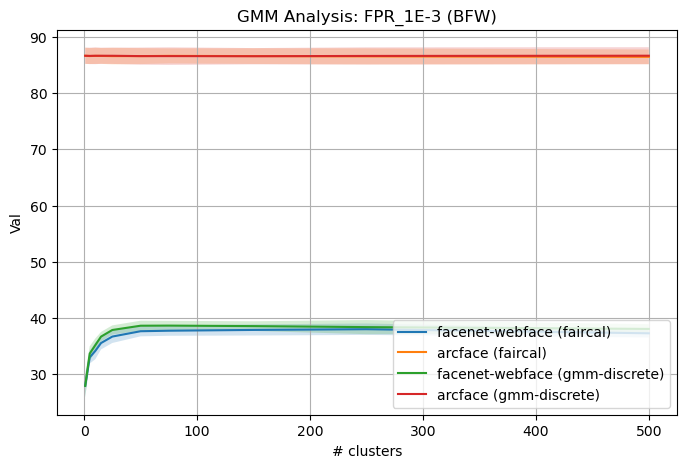

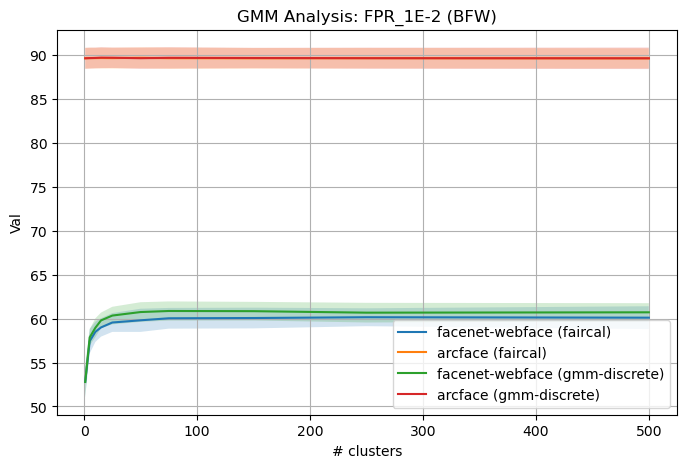

In [16]:
for metric in metrics:
    data[f'{metric}_mean'] = np.nan
    data[f'{metric}_std'] = np.nan
    data[f'{metric}_mean'] = data[metric].apply(lambda x: float(x.split()[0]))
    data[f'{metric}_std'] = data[metric].apply(lambda x: float(x.split()[1][1:-1]))
    data = data.sort_index()
    
    plt.figure(figsize=(8, 5))
    for approach in approaches:
        for model in ["facenet-webface", "arcface"]:
            x = data[f'{metric}_mean']["bfw", model, approach].index
            y = data[f'{metric}_mean']["bfw", model, approach]
            error = data[f'{metric}_std']["bfw", model, approach]
            plt.plot(x,y,label=model+f" ({approach})")
            plt.fill_between(x, y-error, y+error, alpha=0.2)

    plt.legend(loc="lower right")
    plt.grid()
    plt.xlabel("# clusters")
    plt.ylabel("Val")
    plt.title(f"GMM Analysis: {metric.upper()} (BFW)")

    plt.show()

In [17]:
import pandas as pd
gmm_df = pd.read_csv("../times_GMM.txt")
faircal_df = pd.read_csv("../times_faircal.txt")

In [18]:
gmm_df['n_clusters']
faircal_df['n_clusters'] = n_clusters*2

KeyError: 'n_clusters'

In [ ]:
for model in ["facenet", "arcface"]:

    model_gmm = gmm_df[gmm_df["experiment"].str.contains(model)]
    model_faircal = faircal_df[faircal_df["experiment"].str.contains(model)]

    plt.plot(n_clusters, model_gmm["runtime"], marker="x", label="GMM")
    plt.plot(n_clusters, model_faircal["runtime"], marker="x", label="k-means")
    plt.legend()
    plt.grid()
    plt.title(f"Model: {model}")
    plt.ylabel("runtime(s)")
#     plt.xscale("log")
    plt.xlabel("# clusters")
    plt.show()

In [37]:
# cluster shape
dataset = 'bfw'
feature = 'facenet-webface'
n_clusters = 50
fold_nr = 1

def load_GMM(dataset, feature, n_clusters, fold_nr):
    filename = f'../experiments/gmm-discrete/{dataset}_{feature}_nclusters{str(n_clusters)}_fold{str(fold_nr)}'
    results = np.load(f'{filename}.npy', allow_pickle=True).item()
    return results


clusters = load_GMM(dataset, feature, n_clusters, fold_nr)

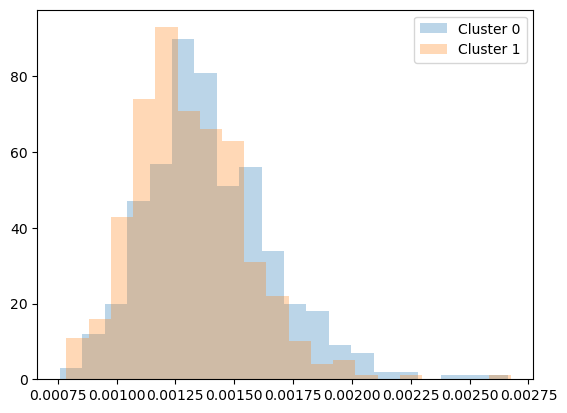

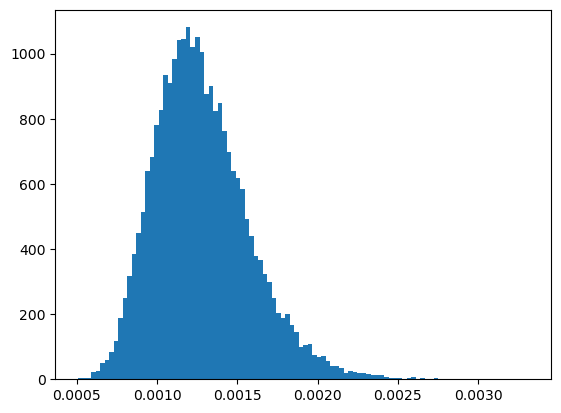

In [38]:
for i in range(2):
    plt.hist(clusters.model_.covariances[i],bins=20, alpha=0.3, label=f"Cluster {i}")
#     plt.plot(clusters.model_.covariances[i], alpha=0.3)
plt.legend()
plt.show()

all_covs = np.hstack(clusters.model_.covariances)
plt.hist(all_covs,bins=100)
plt.show()

In [47]:
diag_ratio = []
for i in range(n_clusters):
    num = max(clusters.model_.covariances[i])
    den = min(clusters.model_.covariances[i])
    diag_ratio.append(float(num/den))

plt.hist(diag_ratio, bin)

[3.503338098526001,
 3.397629976272583,
 3.6888301372528076,
 2.5737555027008057,
 2.7550978660583496,
 2.438373327255249,
 2.99245285987854,
 2.4161880016326904,
 2.706568479537964,
 2.9878854751586914,
 3.2681145668029785,
 3.316041946411133,
 3.5587050914764404,
 3.7730042934417725,
 3.887566566467285,
 5.275790214538574,
 3.388373374938965,
 3.0940909385681152,
 2.922351837158203,
 2.6190481185913086,
 3.0250768661499023,
 2.37782883644104,
 4.051336288452148,
 2.580106019973755,
 2.2349538803100586,
 4.1323466300964355,
 3.25898814201355,
 4.30268669128418,
 2.8431146144866943,
 2.824601650238037,
 3.295381546020508,
 3.264136552810669,
 3.5472748279571533,
 5.409919261932373,
 2.9205210208892822,
 3.7668986320495605,
 3.2859411239624023,
 4.820216178894043,
 2.9975898265838623,
 3.1859724521636963,
 2.922049045562744,
 3.3636157512664795,
 2.9622066020965576,
 3.59728741645813,
 2.8485424518585205,
 2.9592671394348145,
 2.331857442855835,
 2.651113510131836,
 2.885057210922241,
 

In [ ]:
import pickle as pk
emb = pk.load(open("../embeddings/arcface_bfw_embeddings.pk", 'rb'))
emb

In [ ]:
emb_vals = np.vstack(emb['embedding'])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(emb_vals)
X = pca.transform(emb_vals)

In [ ]:
plt.scatter(X[:,0], X[:,1])

In [ ]:
emb["reduced_x"] = X[:,0]
emb["reduced_y"] = X[:,1]
emb

In [ ]:
for category in emb["category"].unique():
    sub_df = emb[emb["category"]==category]
    plt.scatter(sub_df['reduced_x'], sub_df['reduced_y'], label=category)
    
plt.legend()
plt.show()

In [ ]:
dat = np.vstack(emb["embedding"])

In [ ]:
u,v,ut = np.linalg.svd(np.cov(dat.T))

In [ ]:
plt.plot(v)
min(v)